# Yelp Exploration

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import *
from sklearn import metrics

## Data Import

The datasets are large, so we will import each one in separate cells (just in case we only want to run parts of the notebook).

In [3]:
%%time
# reviews = pd.read_csv('input/yelp_review.csv') # will take over 2 minutes
reviews = pd.read_csv('input/yelp_review.csv', nrows=10000) # essentially instant

Wall time: 109 ms


In [4]:
%%time
businesses = pd.read_csv('input/yelp_business.csv')

Wall time: 702 ms


In [6]:
%%time
attributes = pd.read_csv('input/yelp_business_attributes.csv', 
                             dtype='category', na_values='Na', true_values='True', false_values='False')
attributes[attributes.columns[1:]] = attributes[attributes.columns[1:]].apply(lambda x: x.cat.codes)

Wall time: 2.34 s


In [26]:
attributes.columns

Index(['business_id', 'AcceptsInsurance', 'ByAppointmentOnly',
       'BusinessAcceptsCreditCards', 'BusinessParking_garage',
       'BusinessParking_street', 'BusinessParking_validated',
       'BusinessParking_lot', 'BusinessParking_valet',
       'HairSpecializesIn_coloring', 'HairSpecializesIn_africanamerican',
       'HairSpecializesIn_curly', 'HairSpecializesIn_perms',
       'HairSpecializesIn_kids', 'HairSpecializesIn_extensions',
       'HairSpecializesIn_asian', 'HairSpecializesIn_straightperms',
       'RestaurantsPriceRange2', 'GoodForKids', 'WheelchairAccessible',
       'BikeParking', 'Alcohol', 'HasTV', 'NoiseLevel', 'RestaurantsAttire',
       'Music_dj', 'Music_background_music', 'Music_no_music', 'Music_karaoke',
       'Music_live', 'Music_video', 'Music_jukebox', 'Ambience_romantic',
       'Ambience_intimate', 'Ambience_classy', 'Ambience_hipster',
       'Ambience_divey', 'Ambience_touristy', 'Ambience_trendy',
       'Ambience_upscale', 'Ambience_casual', 'Restau

The raw attributes have a lot of Na's.  Also certain columns are not pure True/False.  For now we'll just use the category codes so that we can actually convert to integers.

## EDA

In [10]:
reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


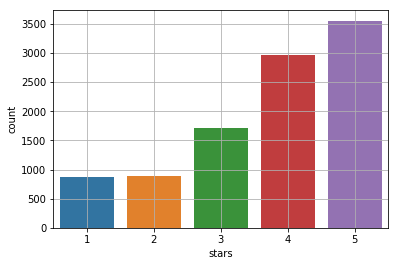

In [5]:
sns.countplot('stars', data=reviews)
plt.grid()
plt.show()

For geographical separation.  We can run KMeans or put this on a maps API later.

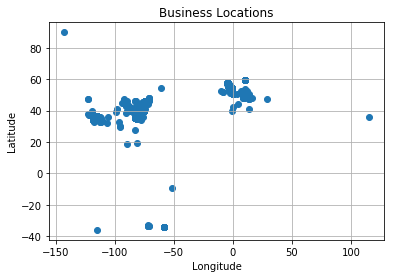

In [81]:
plt.scatter(businesses.longitude, businesses.latitude)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Business Locations')
plt.grid()
plt.show()

We're going to join businesses and attributes now.  Businesses without listed attributes and the converse will be excluded by the inner join.

In [7]:
joined = businesses.merge(attributes, on='business_id').set_index('business_id')
joined.head()

,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService
business_id,,,,,,,,,,,,,,,,,,,,,
FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## Creating Categories Data Frame

Creating this data frame takes a lot of memory.  I suggest running the cells up to the `to_csv()` call once and never running them again (simply run `read_csv()` on subsequent opens). 

In [8]:
n = joined.shape[0]
s = set()
for c in joined.categories:
    s |= set(c.split(';'))

print('Total number of business: %d' % n)
print('Total number of categories: %d' % len(s))


Total number of business: 152041
Total number of categories: 1269


In [9]:
categories = pd.DataFrame(np.zeros((n, len(s))), dtype=np.int8)
categories.columns = sorted(list(s))
categories.index = joined.index

Wall time: 751 ms


In [17]:
%%time

# I know this is a dumb for loop.
# I kept getting errors trying to parallelize so I just gave up.
# We're only running this once anyways.
for i in joined.index:
    for c in joined.loc[i].categories.split(';'):
        categories.loc[i].c = 1

Wall time: 1min 26s


In [20]:
%%time
categories.to_csv('input/categories.csv')

Wall time: 2min 37s


Skip all the cells up to here if you already have `categories.csv`.

In [21]:
%%time
categories = pd.read_csv('input/categories.csv')

Wall time: 19.1 s


## Machine Learning

### Predicting Star with Business Attributes

I'm getting lazy with the naming convention here.  I'll have to fix the `X_train` vs `train_data` naming convention later.  For now, I just need to differentiate between training on the reviews and training on the business attributes.  Also, I'm going to just treat dev and test as the same for now since so most people online seem to do that anyways.

Also, the categories column is valuable but is currently unusable as a semicolon separated string value.  I'll deal with this later.

In [8]:
X_names = joined.columns[13:]
X_names

Index(['AcceptsInsurance', 'ByAppointmentOnly', 'BusinessAcceptsCreditCards',
       'BusinessParking_garage', 'BusinessParking_street',
       'BusinessParking_validated', 'BusinessParking_lot',
       'BusinessParking_valet', 'HairSpecializesIn_coloring',
       'HairSpecializesIn_africanamerican', 'HairSpecializesIn_curly',
       'HairSpecializesIn_perms', 'HairSpecializesIn_kids',
       'HairSpecializesIn_extensions', 'HairSpecializesIn_asian',
       'HairSpecializesIn_straightperms', 'RestaurantsPriceRange2',
       'GoodForKids', 'WheelchairAccessible', 'BikeParking', 'Alcohol',
       'HasTV', 'NoiseLevel', 'RestaurantsAttire', 'Music_dj',
       'Music_background_music', 'Music_no_music', 'Music_karaoke',
       'Music_live', 'Music_video', 'Music_jukebox', 'Ambience_romantic',
       'Ambience_intimate', 'Ambience_classy', 'Ambience_hipster',
       'Ambience_divey', 'Ambience_touristy', 'Ambience_trendy',
       'Ambience_upscale', 'Ambience_casual', 'RestaurantsGoodForGro

In [15]:
np.random.seed(0)
X_train, X_test, y_train, y_test = \
    train_test_split(joined[X_names].values, joined.stars.astype(np.int8).values, test_size=.1)

#### Decision Tree

In [18]:
%%time

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

print(metrics.classification_report(y_test, dt.predict(X_test)))

             precision    recall  f1-score   support

          1       0.33      0.00      0.00       528
          2       0.43      0.04      0.08      2130
          3       0.42      0.39      0.40      4992
          4       0.37      0.63      0.47      5275
          5       0.37      0.23      0.28      2280

avg / total       0.39      0.39      0.35     15205

Wall time: 1.62 s


#### Random Forest

In [19]:
%%time

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

print(metrics.classification_report(y_test, rf.predict(X_test)))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00       528
          2       0.44      0.04      0.08      2130
          3       0.42      0.39      0.40      4992
          4       0.37      0.63      0.47      5275
          5       0.37      0.23      0.28      2280

avg / total       0.38      0.39      0.35     15205

Wall time: 2.95 s


C:\Users\David\Anaconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Predicting Stars with Review Text

In [6]:
np.random.seed(0)
train_data, dev_data, train_labels, dev_labels = \
    train_test_split(reviews.text.values, reviews.stars.values, test_size=.1)

#### Count Vectorizer

In [9]:
%%time
cv = CountVectorizer(stop_words='english')
train_dtm = cv.fit_transform(train_data)
dev_dtm = cv.transform(dev_data)

lr = LogisticRegression()
lr.fit(train_dtm, train_labels)

print(metrics.classification_report(dev_labels, lr.predict(dev_dtm)))

             precision    recall  f1-score   support

          1       0.69      0.63      0.66        94
          2       0.38      0.30      0.33        87
          3       0.38      0.30      0.34       175
          4       0.46      0.51      0.49       300
          5       0.61      0.66      0.64       344

avg / total       0.51      0.52      0.51      1000

Wall time: 4.66 s


In [67]:
len(cv.get_feature_names())

29890

#### TFIDF Vectorizer

In [84]:
tv = TfidfVectorizer(stop_words='english')
train_dtm2 = tv.fit_transform(train_data)
dev_dtm2 = tv.transform(dev_data)

lr2 = LogisticRegression()
lr2.fit(train_dtm2, train_labels)

print(metrics.classification_report(dev_labels, lr2.predict(dev_dtm2)))

             precision    recall  f1-score   support

          1       0.77      0.54      0.64        94
          2       0.47      0.09      0.15        87
          3       0.47      0.29      0.36       175
          4       0.48      0.57      0.52       300
          5       0.59      0.78      0.68       344

avg / total       0.54      0.55      0.52      1000



#### SVM

Interestingly, an SVM is horrible if we use the count vectorizer but on par with logistic regression if we use the tf-idf vectorizer.  Fitting is also much faster with tf-idf as well.

In [88]:
svc = LinearSVC()
svc.fit(train_dtm, train_labels)
print(metrics.classification_report(dev_labels, svc.predict(dev_dtm)))

             precision    recall  f1-score   support

          1       0.10      0.10      0.10        94
          2       0.10      0.09      0.10        87
          3       0.21      0.22      0.21       175
          4       0.32      0.33      0.33       300
          5       0.33      0.33      0.33       344

avg / total       0.27      0.27      0.27      1000



In [89]:
svc2 = LinearSVC()
svc2.fit(train_dtm2, train_labels)
print(metrics.classification_report(dev_labels, svc2.predict(dev_dtm2)))

             precision    recall  f1-score   support

          1       0.68      0.65      0.66        94
          2       0.38      0.24      0.30        87
          3       0.38      0.33      0.35       175
          4       0.45      0.50      0.47       300
          5       0.62      0.68      0.65       344

avg / total       0.51      0.52      0.52      1000

